In [1]:
 #12 de Marzo de 2019

#Required packages
library(devtools)
library(BiocManager)
#BiocManager::install("pcaMethods", version= "3.8")
#devtools::install_github('kimsche/MetaboMate', build_vignettes=TRUE)
library(MetaboMate)
#devtools::install_github('jwist/visualizeR')
library(car)


Attaching package: ‘BiocManager’

The following object is masked from ‘package:devtools’:

    install

Loading required package: carData


In [7]:
Metadata <-read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/Propoleo_metadata.csv', header= TRUE, sep= ";")
dim(Metadata)

[1] 123  16

In [17]:
part1 <- rev(read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/data_part1.csv', header= FALSE, sep= ";"))
dim(part1)
part2 <- rev(read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/data_part2.csv', header= FALSE, sep= ";"))
dim(part2)

[1] 131072     61

[1] 131072     62

In [28]:
X <- cbind(part1, part2)
dim(X)
colnames(X) <- seq_along(X[1,])

[1] 131072    123

In [29]:
#load(url('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/data_part1.csv'))
#load(url('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/data_part2.csv'))
      


#setwd("C:/Users/ASUS/Documents/Propoleo_processed/Metabomate/Data")

#Importing data to Metabomate (Row x Col)


ppm <- read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/ppmpro_all_center.csv', header= FALSE)

In [30]:
a_intensity <- t(X)
ppm <- t(ppm)

dim(a_intensity)
dim(Metadata)
dim(ppm)

[1]    123 131072

[1] 123  16

[1] 131072      1

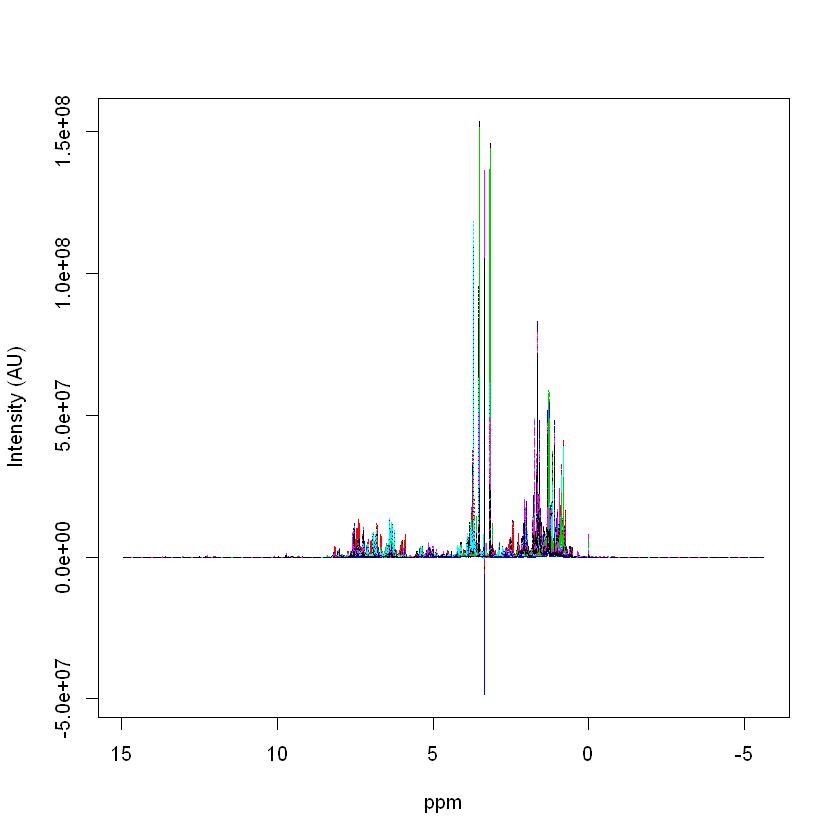

In [4]:
#Bad shimming 
X <- a_intensity[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Eliminar espectros con shims malos
Metadata_f <- Metadata[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Eliminar espectros con shims malos
ColorRGB <- data.frame(Metadata_f$SampleNMR, Metadata_f$R, Metadata_f$G, Metadata_f$B)

matspec(ppm, X, shift= range(ppm))

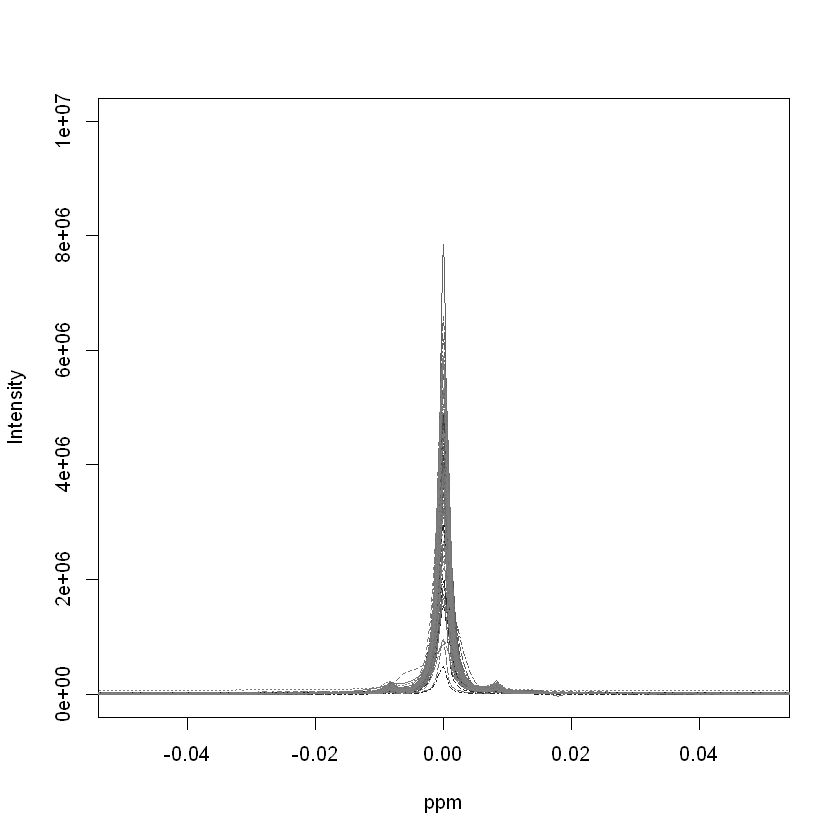

In [5]:
#Spectra Calibration
X.cali=calibration(X, ppm, type='Urine')
        
#Visualization
Gray <- gray.colors(115, start=0.1, end=0.5, gamma=2.2, alpha=NULL)

matplot(t(ppm),t(X.cali), type=("l"), xlim = c(-0.05,0.05), ylim=c(-1e4, 1e7), xlab="ppm", ylab="Intensity", col=Gray)


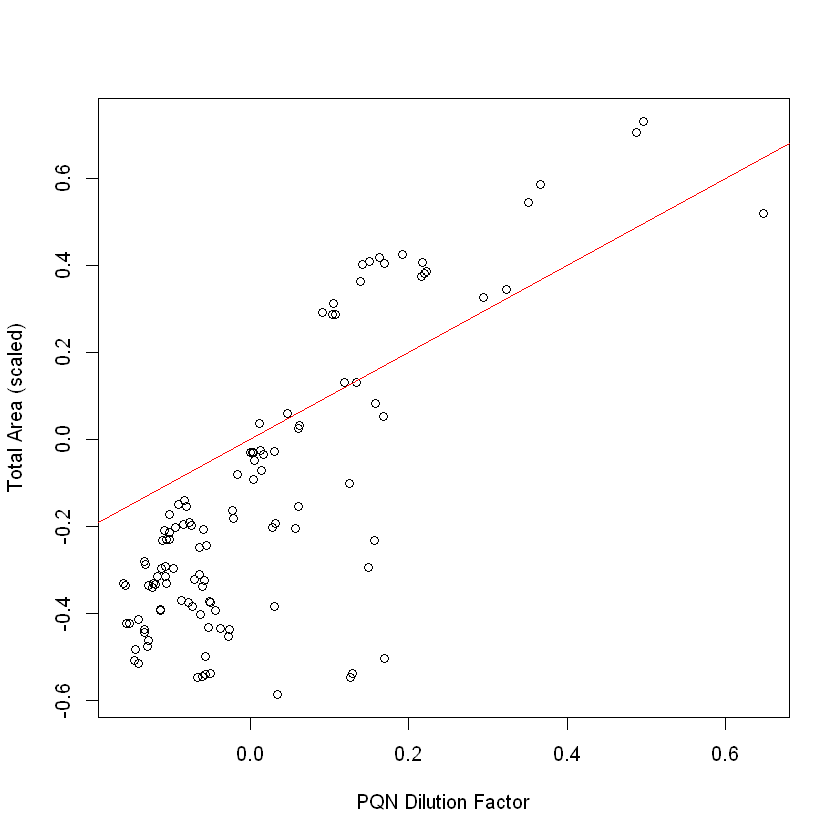

In [6]:
#Indexing of chemical shifts regions

idx.TMS= get.idx(range=c(min(ppm),0.5), ppm)
idx.meoh1= get.idx(range=c(3.15,3.29), ppm)
idx.meoh2= get.idx(range=c(3.32,3.38), ppm)
idx.meoh3= get.idx(range=c(3.51,3.54), ppm)
idx.water= get.idx(range=c(4.84,4.94), ppm)
idx.noise= get.idx(range=c(14,max(ppm)), ppm)

#Excision of undesired regions

X.cali=X.cali[,-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]
ppm=ppm[-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]

#Baseline correction

X.bl=bline(X.cali)

#Spectral normalisation

X.pqn= pqn(X.bl, add.DilF = 'dilF.pqn')
X.ta= totalArea(X.bl, add.DilF = 'dilF.ta')

plot(log10(dilF.pqn), log10(dilF.ta), xlab='PQN Dilution Factor', ylab='Total Area (scaled)')
abline(a = c(0,1), col='red')

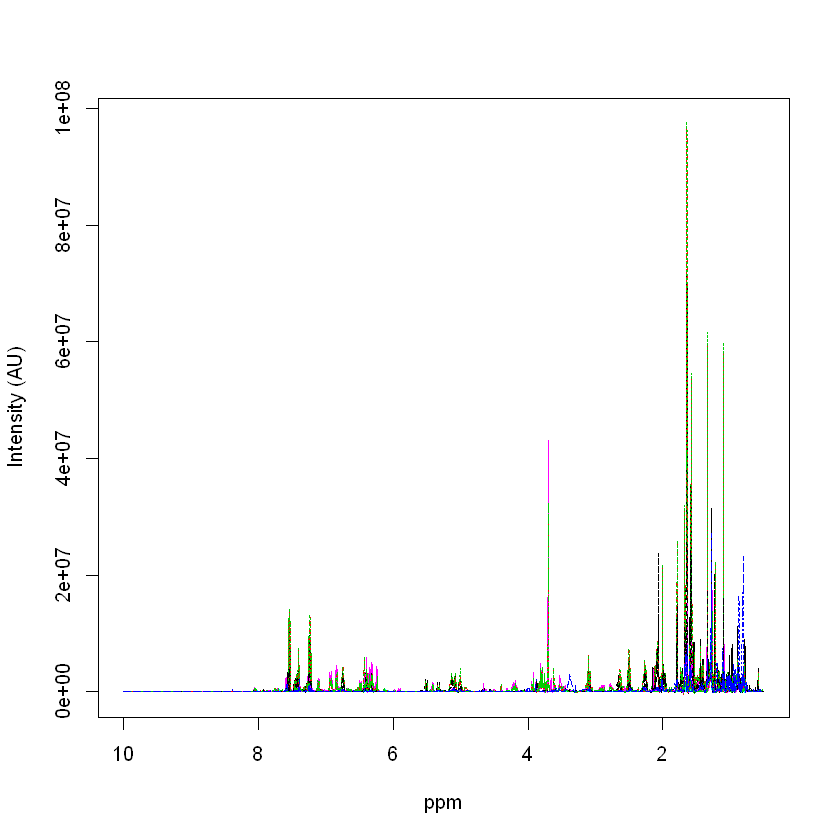

In [7]:
#Visualisation

matspec(ppm, X.pqn[1:10,], shift = c(0,10))

iterations: 19
iterations: 49
[1] 115   2
[1] 83970     2


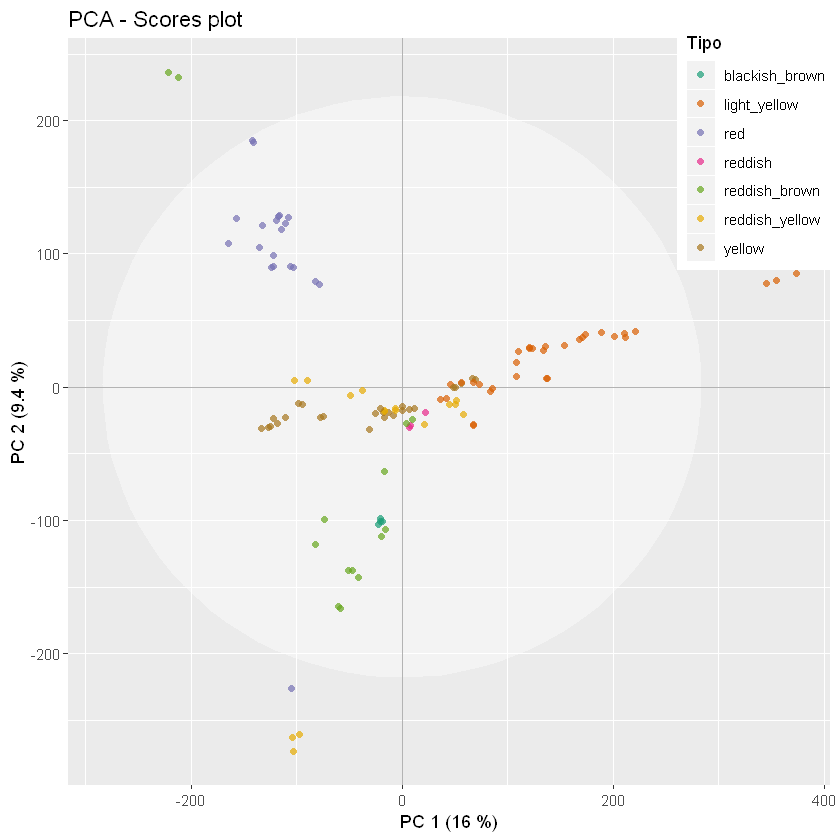

In [8]:
#PCA

pca.model=pca(X=X.pqn, pc=2, scale='UV', center=TRUE)

plotscores(model=pca.model, pc=c(1,2), an=list(Tipo=Metadata_f$Color), title='PCA - Scores plot')

Warning message in if (grepl("stat|recon", type, ignore.case = T)) {:
"la condición tiene longitud > 1 y sólo el primer elemento será usado"

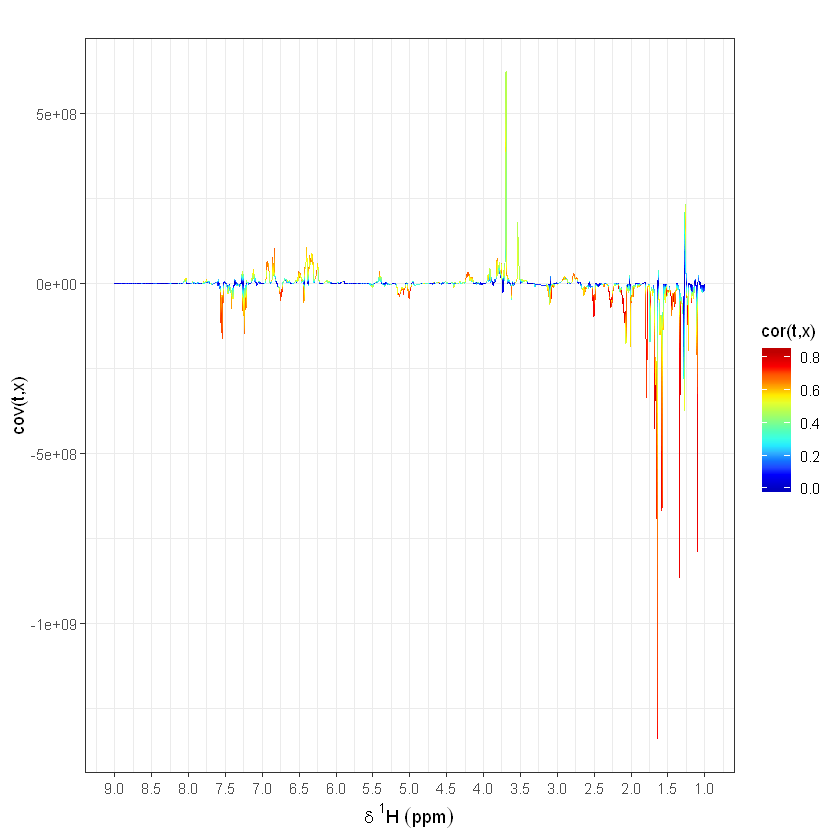

In [9]:
plotload(pca.model, X.pqn, ppm, pc=2, shift=c(1,9))